# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

In [2]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()

2.19.0


''

## Populating namespaces

In [3]:
# Utility Pkgs
import os
import shutil
import random
import itertools
import warnings

import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import tools
import plotly.graph_objs as go

# Image Handling
import cv2
import imutils
from PIL import Image
from tqdm import tqdm

# Model building
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

warnings.filterwarnings("ignore")

In [4]:
!pip install visualkeras

# Visualize model
from visualkeras import layered_view

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.1 MB/s eta 0:00:00


In [5]:
base_path = '/content/'
cell_images_dir = os.path.join(base_path,'cell_images')
train_data_path = os.path.join(base_path,'train')
testing_path = os.path.join(base_path,'test')

## Prepare DataSet

### *Download* DataSet

In [6]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

--2025-10-06 20:57:14--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 13.225.47.111, 13.225.47.51, 13.225.47.63, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|13.225.47.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M   240MB/s    in 1.4s    

2025-10-06 20:57:15 (240 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  sample_data


## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


In [7]:
BASE_DIR = '/content/cell_images'
DATA_DIR = os.path.join(BASE_DIR)
TRAIN_DIR = os.path.join(BASE_DIR, 'malaria_dataset/train')
TEST_DIR = os.path.join(BASE_DIR, 'malaria_dataset/test')

print(f"Data Directory: {DATA_DIR}")
print(f"Training Directory: {TRAIN_DIR}")
print(f"Testing Directory: {TEST_DIR}")

Data Directory: /content/cell_images
Training Directory: /content/cell_images/malaria_dataset/train
Testing Directory: /content/cell_images/malaria_dataset/test


# Data Exploration

In [8]:
def load_data(dir_path, img_size=(128, 128)):
    """
    Load images from subfolders and resize them into NumPy arrays.
    Each subfolder inside dir_path represents a class label.
    """
    X = []
    y = []
    i = 0
    labels = dict()

    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):  # skip hidden files/folders
            labels[i] = path
            folder_path = os.path.join(dir_path, path)

            for file in os.listdir(folder_path):
                if not file.startswith('.') and file.endswith('.png'):  # skip hidden files/folders
                    img = cv2.imread(os.path.join(folder_path, file))
                    img = cv2.resize(img, img_size)  # resize
                    X.append(img)
                    y.append(i)
            i += 1

    X = np.array(X)
    y = np.array(y)

    print(f'{len(X)} images loaded from {dir_path}.')

    return X, y, labels

In [9]:
def get_class_types(data_dir: str):
    """
    Loops through the given directory and returns a list of class names
    (subdirectory names inside data_dir).
    """
    class_types = [
        d for d in os.listdir(data_dir)
        if os.path.isdir(os.path.join(data_dir, d))
    ]
    return sorted(class_types)

In [10]:
CLASS_TYPES = get_class_types("./cell_images")
N_TYPES = len(CLASS_TYPES)

print("Classes found:", CLASS_TYPES)
print("Number of classes:", N_TYPES)

Classes found: ['Parasitized', 'Uninfected']
Number of classes: 2


In [21]:
X_train, y_train, train_labels = load_data(
    dir_path="./cell_images",
    img_size=(150, 150)
)

100%|██████████| 2/2 [00:19<00:00,  9.51s/it]


27558 images loaded from ./cell_images.


In [23]:
print(train_labels)

{0: 'Parasitized', 1: 'Uninfected'}


Label 0


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
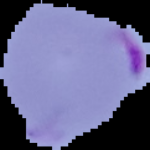

In [25]:
print(f"Label {y_train[200]}")
X_train[200]

Label 1


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
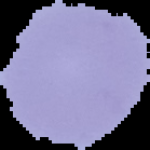

In [28]:
print(f"Label {y_train[20001]}")
X_train[20001]

In [29]:
def plot_sample_images(
    X,
    y,
    class_names=None,
    im_size=150,
    figsize=(13, 10),
    index_list=None
):
    if index_list is None:
        index_list = range(12)  # default: show first 12

    n_images = len(index_list)
    n_cols = 4
    n_rows = (n_images + n_cols - 1) // n_cols

    plt.figure(figsize=figsize)

    for i, idx in enumerate(index_list):
        plt.subplot(n_rows, n_cols, i + 1)

        # Show image
        plt.imshow(X[idx].squeeze(), cmap="gray")
        plt.axis("off")

        # Label
        label = y[idx]
        if class_names is not None and isinstance(label, (int, np.integer)):
            label = class_names[label]

        plt.title(f"{idx}: {label}", fontsize=10)

    plt.tight_layout()
    plt.show()

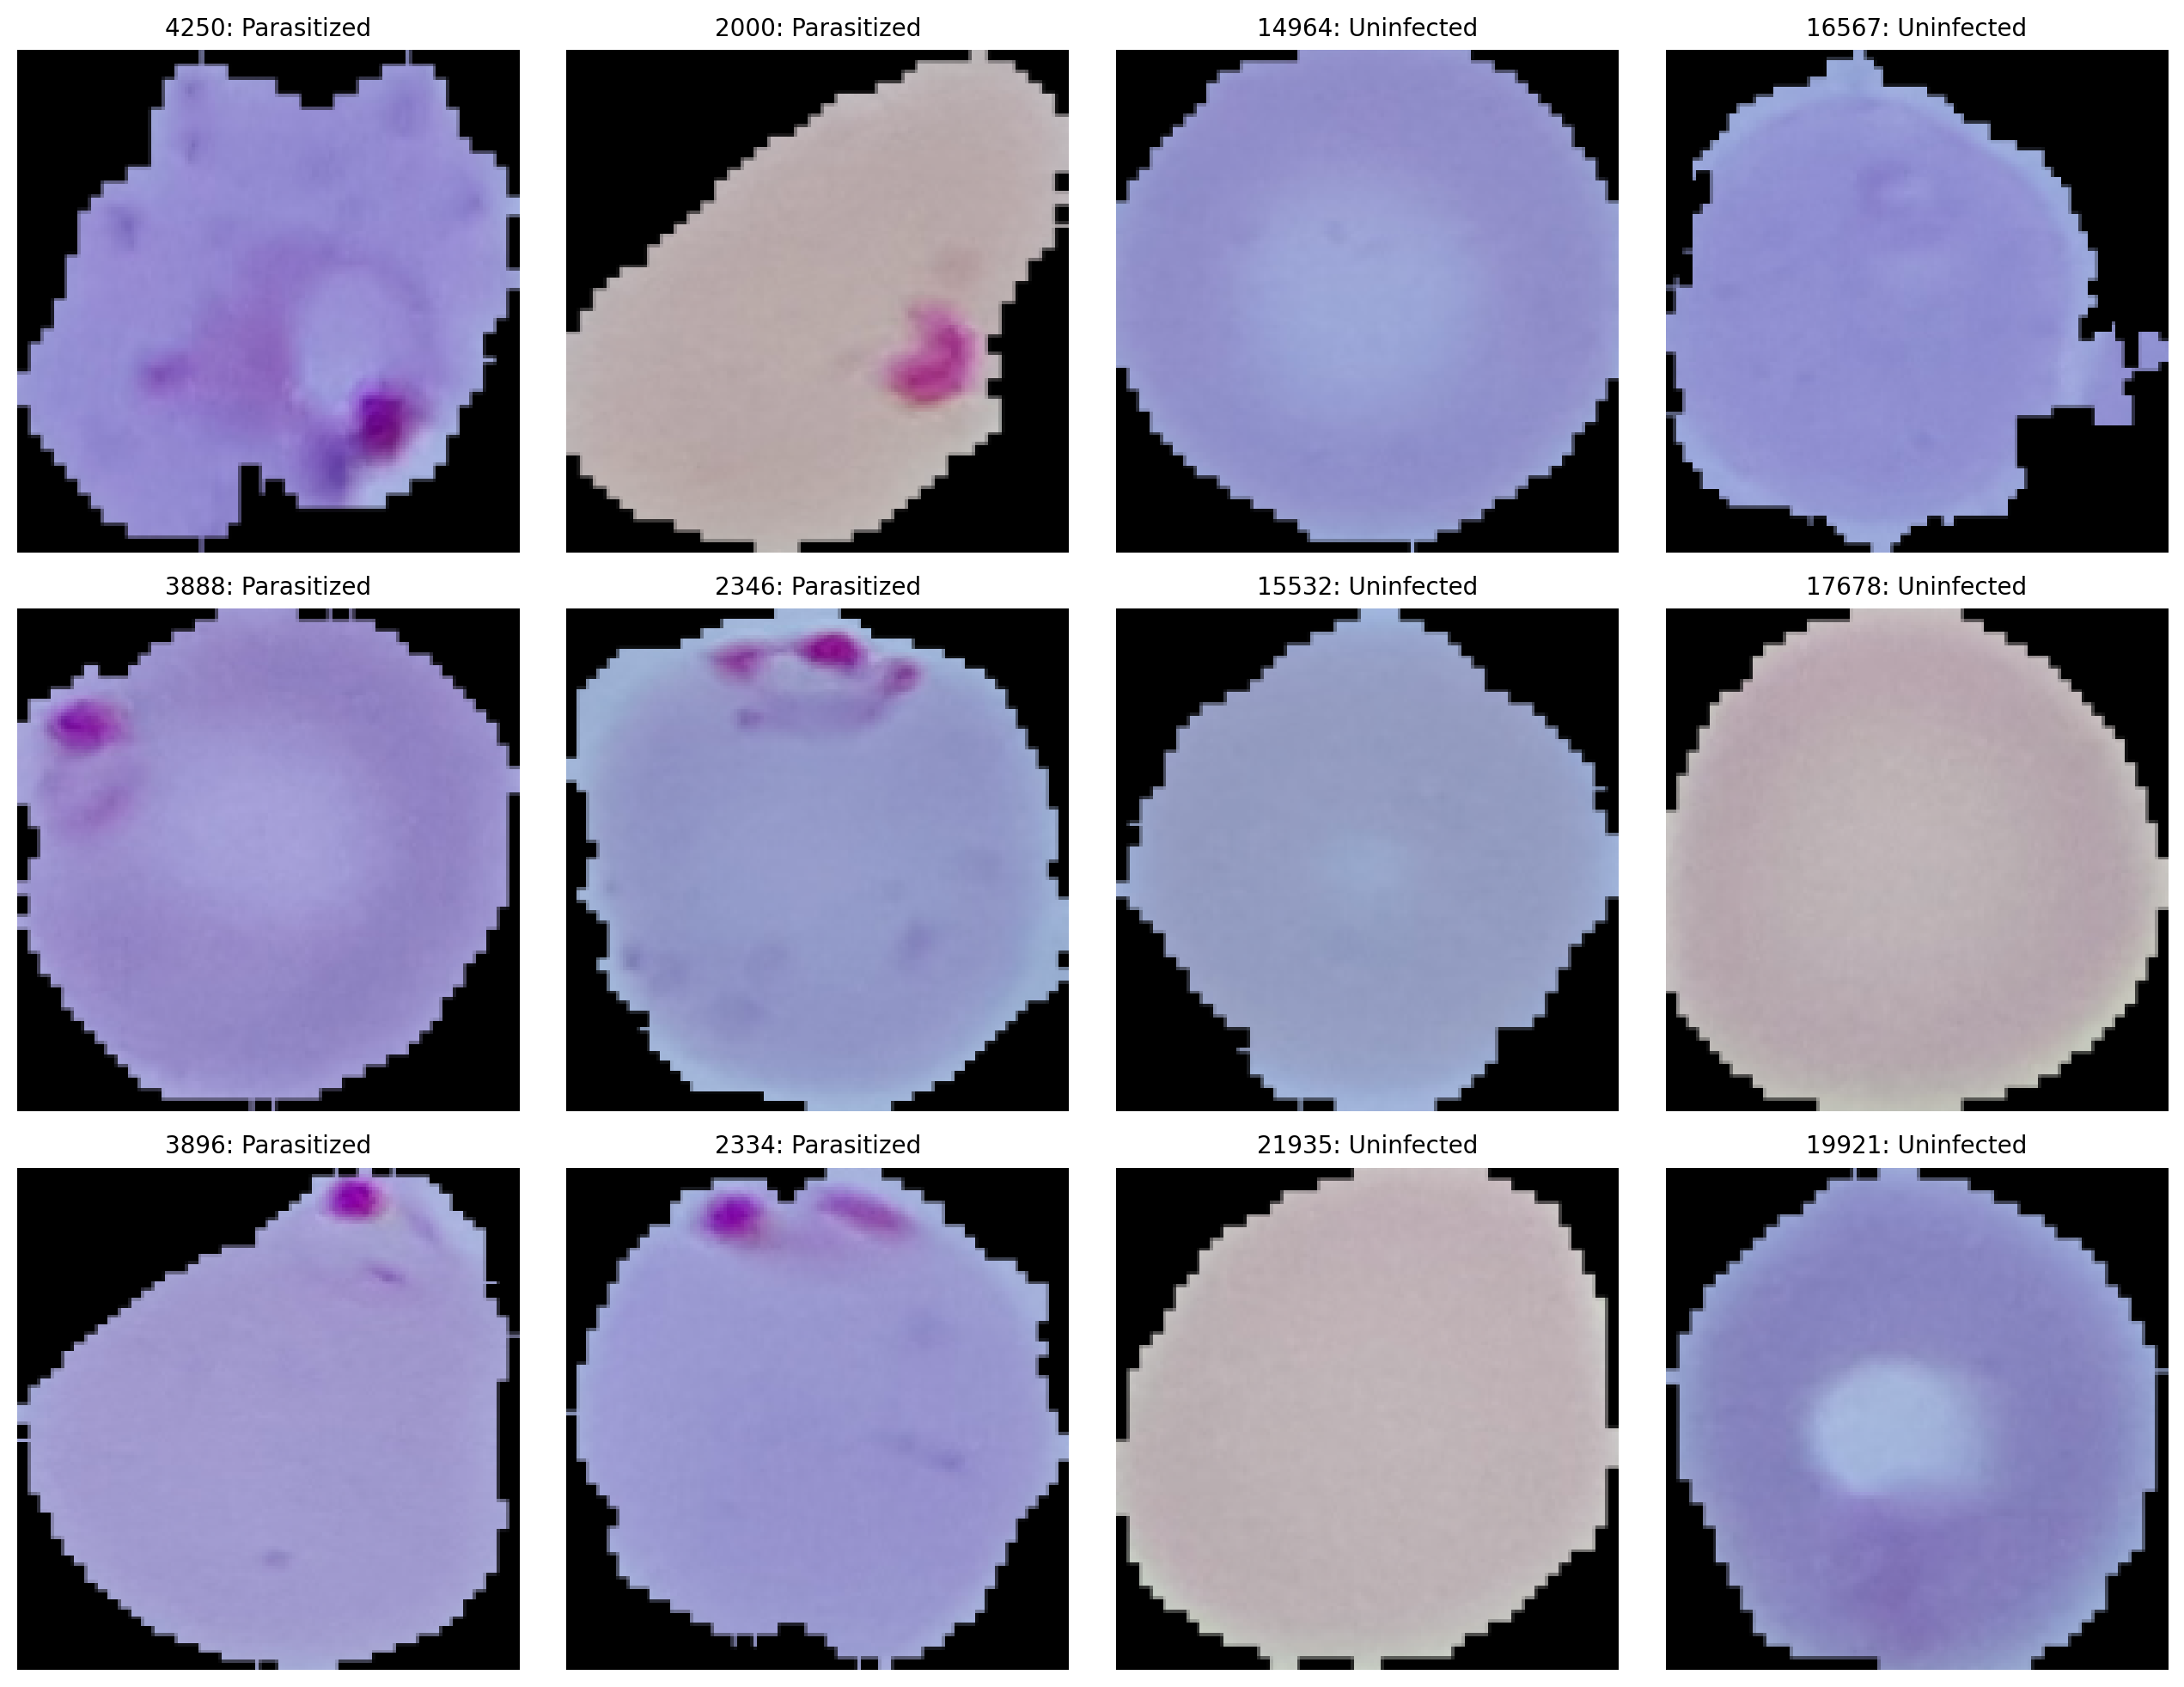

In [31]:
plot_sample_images(
    X_train,
    y_train,
    class_names=train_labels,
    im_size=350,
    figsize=(13, 10),
    index_list=[
        4250, 2000, 14964, 16567,
        3888, 2346, 15532, 17678,
        3896, 2334, 21935, 19921
    ]
)

# Data Preparation



In [11]:
def split_data(source_dir, train_dir, test_dir, split_size=0.8):
    if os.path.exists(train_dir):
        print("Dataset directory already exists. Removing and re-splitting.")
        shutil.rmtree(os.path.dirname(train_dir))
    print("Creating new dataset directories...")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    for category in ['Parasitized', 'Uninfected']:
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)
        category_source_path = os.path.join(source_dir, category)
        images = [f for f in os.listdir(category_source_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images)
        split_point = int(len(images) * split_size)
        train_images = images[:split_point]
        test_images = images[split_point:]
        for img in train_images:
            shutil.copy(os.path.join(category_source_path, img), os.path.join(train_dir, category, img))
        for img in test_images:
            shutil.copy(os.path.join(category_source_path, img), os.path.join(test_dir, category, img))
    print("Data splitting complete.")

In [12]:
split_data(DATA_DIR, TRAIN_DIR, TEST_DIR)

Creating new dataset directories...
Data splitting complete.


In [13]:
IMG_WIDTH, IMG_HEIGHT = 128, 128
BATCH_SIZE = 32

In [36]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [37]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 17638 images belonging to 2 classes.
Found 4408 images belonging to 2 classes.


In [38]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [39]:
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 5512 images belonging to 2 classes.


# Evaluation Framework

In [40]:
def evaluate_model(model, history, test_generator):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # Save the learning curves
    plt.savefig('learning_curves.png')
    plt.show()

    Y_pred = model.predict(test_generator)
    y_pred = np.round(Y_pred)
    y_true = test_generator.classes
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Parasitized', 'Uninfected']))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Parasitized', 'Uninfected'], rotation=45)
    plt.yticks(tick_marks, ['Parasitized', 'Uninfected'])
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    # Save the confusion matrix
    plt.savefig('confusion_matrix.png')
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, Y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    # Save the ROC curve
    plt.savefig('roc_curve.png')
    plt.show()


# First Model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,914,369 (11.12 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 122s 236ms/step - accuracy: 0.7951 - loss: 0.4261 - val_accuracy: 0.8693 - val_loss: 0.3025
Epoch 2/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 87s 195ms/step - accuracy: 0.8831 - loss: 0.2869 - val_accuracy: 0.8849 - val_loss: 0.2796
Epoch 3/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 86s 193ms/step - accuracy: 0.8948 - loss: 0.2618 - val_accuracy: 0.8830 - val_loss: 0.2658
Epoch 4/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 87s 194ms/step - accuracy: 0.8958 - loss: 0.2585 - val_accuracy: 0.8827 - val_loss: 0.2842
Epoch 5/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 88s 197ms/step - accuracy: 0.8967 - loss: 0.2587 - val_accuracy: 0.8838 - val_loss: 0.2731
Epoch 6/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 88s 198ms/step - accuracy: 0.9063 - loss: 0.2411 - val_accuracy: 0.8950 - val_loss: 0.2472
Epoch 7/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 89s 198ms/step - accuracy: 0.9060 - loss: 0.2353 - val_accuracy: 0.8774 - val_loss: 0.2834
Epoch 8/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 90s 202ms/step - accuracy: 0.9057 - loss: 

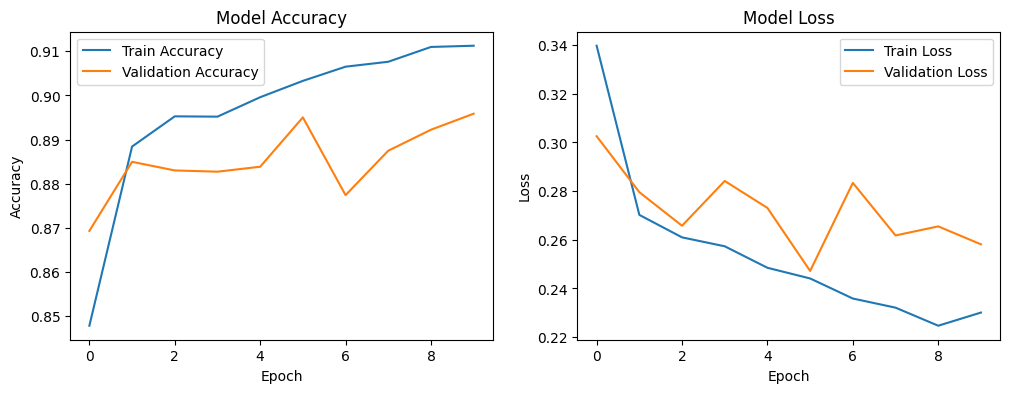

140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step

Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.98      0.87      0.92      2756
  Uninfected       0.83      0.97      0.89      1711

    accuracy                           0.91      4467
   macro avg       0.90      0.92      0.91      4467
weighted avg       0.92      0.91      0.91      4467



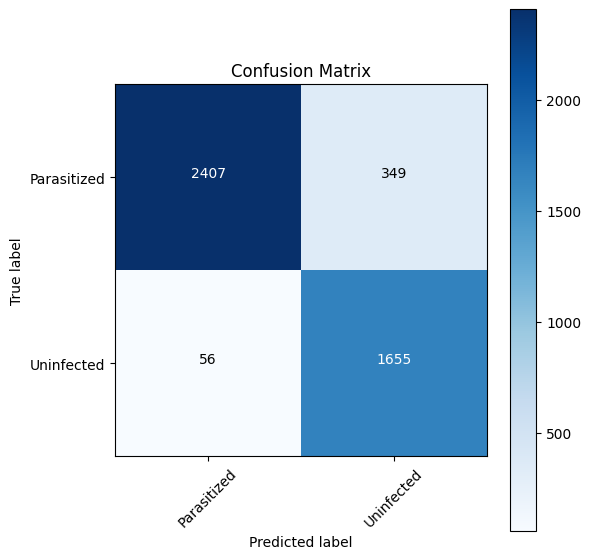

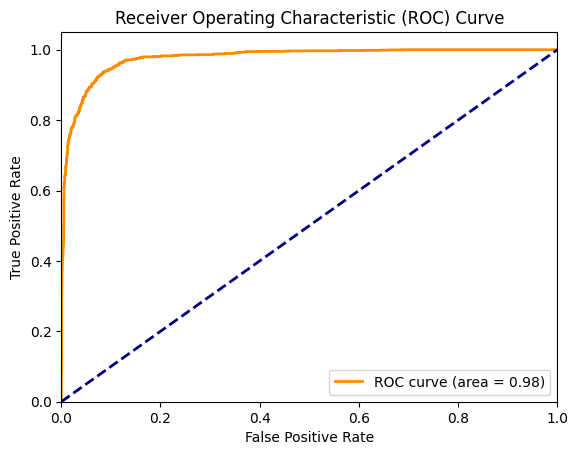

Model saved to malaria_mobilenet_model.h5


In [14]:
def create_mobilenet_model(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# 1. Create the model
mobilenet_model = create_mobilenet_model()
mobilenet_model.summary()

# 2. Train the model
history_mobilenet = mobilenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# 3. Evaluate the model
evaluate_model(mobilenet_model, history_mobilenet, test_generator)

# Save the trained model
mobilenet_model.save('malaria_mobilenet_model.h5')
print("Model saved to malaria_mobilenet_model.h5")

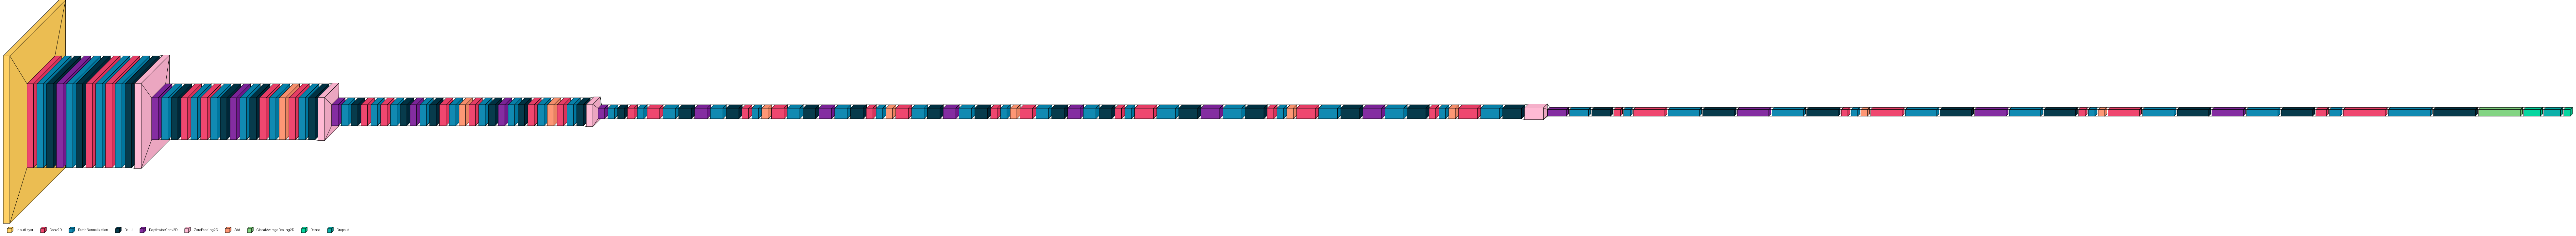

In [23]:
layered_view(mobilenet_model, legend=True, max_xy=10000)

# Model Fine Tuning


Number of layers in the model:  158


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,914,369 (11.12 MB)

 Trainable params: 2,400,705 (9.16 MB)

 Non-trainable params: 513,664 (1.96 MB)

Epoch 1/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 129s 243ms/step - accuracy: 0.8719 - loss: 0.3216 - val_accuracy: 0.8541 - val_loss: 0.3925
Epoch 2/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 89s 198ms/step - accuracy: 0.9067 - loss: 0.2433 - val_accuracy: 0.8553 - val_loss: 0.3940
Epoch 3/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 90s 202ms/step - accuracy: 0.9166 - loss: 0.2092 - val_accuracy: 0.8928 - val_loss: 0.2924
Epoch 4/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 90s 201ms/step - accuracy: 0.9227 - loss: 0.2014 - val_accuracy: 0.9073 - val_loss: 0.2340
Epoch 5/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 142s 201ms/step - accuracy: 0.9282 - loss: 0.1912 - val_accuracy: 0.9208 - val_loss: 0.1930


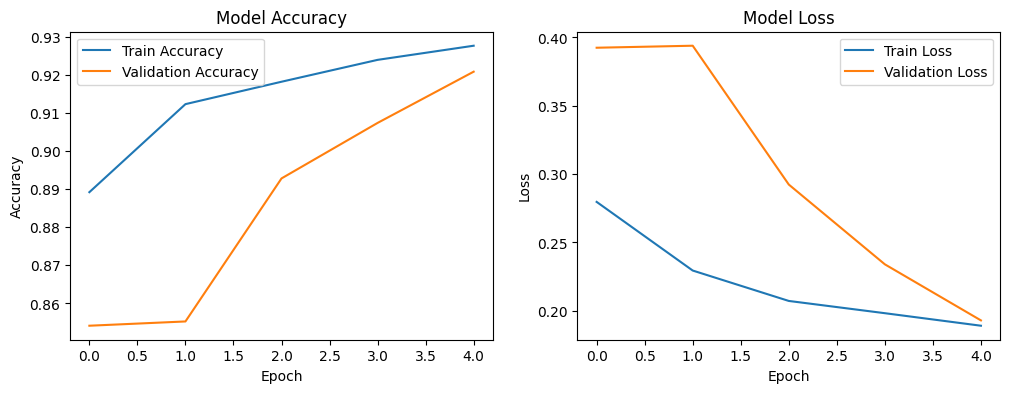

140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step

Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.98      0.92      0.95      2756
  Uninfected       0.89      0.98      0.93      1711

    accuracy                           0.94      4467
   macro avg       0.94      0.95      0.94      4467
weighted avg       0.95      0.94      0.94      4467



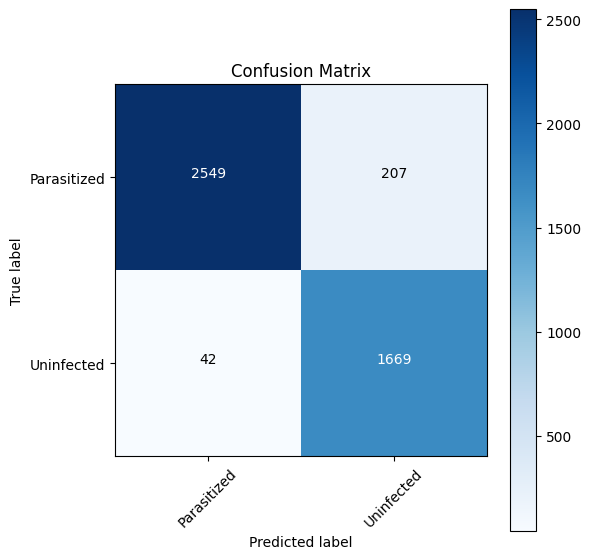

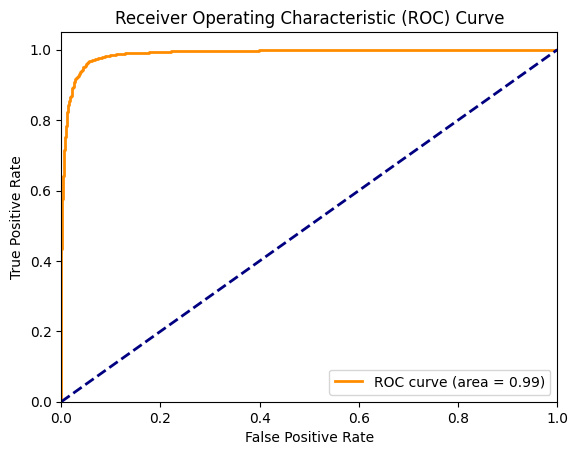

Fine-tuned model saved to malaria_mobilenet_model_tuned.h5


In [15]:
# Fine-tune the MobileNetV2 model

all_layers = mobilenet_model.layers
print("Number of layers in the model: ", len(all_layers))

fine_tune_from_layer = 50
for layer in all_layers[len(all_layers) - fine_tune_from_layer:]:
    layer.trainable = True

for layer in all_layers[:len(all_layers) - fine_tune_from_layer]:
    layer.trainable = False


mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()

history_mobilenet_tuned = mobilenet_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

# Evaluate the fine-tuned model
evaluate_model(mobilenet_model, history_mobilenet_tuned, test_generator)


mobilenet_model.save('malaria_mobilenet_model_tuned.h5')
print("Fine-tuned model saved to malaria_mobilenet_model_tuned.h5")

In [16]:
from google.colab import files

files.download('malaria_mobilenet_model_tuned.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>